# dFLWL-EFO framework for real-time FIRO decision support during flood season

In this demo, we implement dFLWL-EFO to the major flood season of a specific water year (i.e., WY 2017) in Folsom Lake. 

Information of Folsom Lake real-world storage regulation curve and constraints (USACE et al., 2019) are listed below:\
Major flood control season: Nov.19 - Feb.28 \
Storage capacity: 967 TAF (thousand acre-feet) (without accounting for emergency flood space)\
Storage at the top of variable flood control pool: 567 TAF (during major flood season)\
Storage at the top of water conservation pool: 367 TAF (during major flood season)

Flood control goal: \
Control a 1/100 annual chance event to the normal objective release of 115,000 cfs (=228 TAF/day).\
Control a 1/200 annual chance event to a maximum release of 160,000 cfs (=317 TAF/day)

Ramping rate constraints:\
1 - Release between 8,000 cfs and 30,000 cfs will not be increased by more than 10,000 cfs during 2 hour period\
2 - Release between 30,000 cfs and 115,000 cfs will not be increased by more than 30,000 cfs during 2 hour period\
3 - Release between 8,000 cfs and 115,000 cfs will not be decreased by more than 10,000 cfs during 2 hour period

Note: 1 cfs = 1.9835 af/day 

## import necessary modules

In [1]:
# modules defined in this study
from utils import bma_module # functions to implement BMA to generate BMA-PDFs of forecasted inflow within the forecast horizon
from utils import efo_model # functions to implement the EFO
from utils import dflwl_model # functions to implement the modified dFLWL model to utilize the BMA-PDFs
from utils import gdrom_folsom # pre-derived operations rules for Folsom Lake via the GDROM 


# other modules used in this notebook
from os import listdir
from os.path import isfile, join
import re

import pandas as pd
import numpy as np
import copy

from matplotlib import pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns

## Model setting
- based on real-world operational constraints & operators' preferences and judgements

In [2]:
#%%%%%% real-world storage regulation curve (only considering major flood season)
# units: TAF (thousand acre-feet)
# res_S_max, S_old_conser are associated with reservoir attributes, which can be obtained from the real-world rule curve 
# W_N: the storage difference btw. the target water conservation level at the end of flood season and the FLWL (i.e., the upper bound of original water conservation pool); 

res_S_max = 967 # usable storage capacity (i.e., storage corresponding to target water conservation level by the end of flood season)
S_old_conser = 367 # storage corresponding to FLWL
W_N = res_S_max - S_old_conser

In [3]:
#%%%%%% real-world operational constraints
# units: TAF, 1 cfs = 1.9835 acre-feet/day
# R1, current day (i.e., Stage 1) release in volume
# R1_min will be determined by GDROM (provided later)

I_thresh = 30*1.9835 # inflow threshold to determine if there is ongoing flood at current day
R1_max = 115*1.9835 # normal flood control objective release 

# Ramping rate constraints
R1_increase_limit = 80*1.9835 # assuming I0=0 (I0, inflow rate of the previous day), calculated based on ramping rate constraints-1&2
R1_recession_limit = 60*1.9835 # assuming I0=115 kcfs, calculated based on ramping rate constraints-3

In [4]:
#%%%%%% customizable parameters in dFLWL-EFO
selected_horizon = 7 # selected forecast horizon
W_max = 400 # the upper bound of carryover capacity (FIRO space) during major flood season, in TAF
W_F = 400 # the upper bound of risk-tolerance based flood control capacity during major flood season, in TAF

########## parameters of the dFLWL model
# w: a weight assigned to flood control objective; (1-w), a weight assigned to water conservation
# m: an conponent to define the shape of the loss function, m>1 to ensure the convexity
w = 0.9
m = 3

# r_alpha: risk tolerance levels used in dFLWL model under a forecast horizon of 7 days 
dFLWL_r_alpha = 0.15

# R2_max: downstream flood conveyance capacity at Stage 2 under a forecast horizon of 7 days 
# R2_max was derived from historical release series (unit: TAF)
R2_max = 487.4

########## parameters of the EFO model
# risk-tolerance curve for flood control releases, which is generated based on the X1=5, X2=0.37 (at day 15)
df_risk_tolerance = pd.read_csv(r'...\data\EFO_risk_tolerance_curve.csv')
EFO_risk_tolerance = df_risk_tolerance['risk tolerance'].tolist()


## Run the dFLWL-EFO for a flood season

In [15]:
#%%%%%%%%%%% read necessary files
# read the folder that saves daily-updated ensemble streamflow forecasts
daily_ens_folder = "...\\data\\CNRFC_daily_ensemble\\"

# read the calibrated parameters of the BMA model (calibrated using R package 'ensembleBMA' externally)
BMA_parameters = pd.read_csv(r'...\data\BMA_paras_7day_horizon.csv', usecols=[1, 2])
# read the fitted lambda value of the Box-Cox transformation (required in implementing BMA model)
df_lambda = pd.read_csv(r'...\data\Box_Cox_trans_lambda.csv') 
fitted_lambda = df_lambda.loc[df_lambda['n_day']==selected_horizon,:]['fitted_lambda'].values

# read observed operation data
df_obs = pd.read_csv(r'...\data\Folsom_observed_operations.csv')
df_obs['date'] = pd.to_datetime(df_obs['date'])
# convert units: 1 million cubic meter (mcm) = 0.8107144 thousand acre-feet
df_obs.loc[:,'I1'] = df_obs['netinflow-mcm'] * 0.8107144
df_obs.loc[:,'S0_obs'] = df_obs['storage-mcm'] * 0.8107144
df_obs.loc[:,'R1_obs'] = df_obs['outflow-mcm'] * 0.8107144
df_obs['S1_obs'] = df_obs['S0_obs'].shift(-1) # S1: daily ending storage

In [6]:
#%%%%%%%%%%% 
# specify the study period
starting_date = '2016-11-18'
ending_date = '2017-02-28'
chosen_period = pd.date_range(start=starting_date, end=ending_date)
# specify the number of ensemble members
ensemble_number = 59

In [ ]:
#%%%%%%%%%%% 
# create a dataframe to save results
df_result = pd.DataFrame(columns  = ['date', 'W1_opt', 'delta_opt', 'delta_min', 'case_num', 'I1', 'R1_FIRO', 'W1_FIRO', 'S1_FIRO', 'I2_expected'])

# model initialization
S0 = df_obs.loc[df_obs['date'] == starting_date, 'S0_obs'].values[0] # initial storage of the study period (observed value)
W0 = S0 - S_old_conser # initial carryover storage of the study period
R1_0 = df_obs.loc[df_obs['date'] == starting_date, 'R1_obs'].values[0]

# range of MVs of carryover storage (water conservation benefit)
f1_W1_0 = dflwl_model.f_L1_W1(0,W_N,w,m) # MV of W1 when W1=0
f1_W1_max = dflwl_model.f_L1_W1(W_max,W_N,w,m) # MV of W1 when W1=W_max
print("range of MVs of carryover storage:")
print([f1_W1_0, f1_W1_max])

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# dFLWL-EFO implemention: rolling-window simulation 
for date in chosen_period:
    current_date = date.strftime('%Y-%m-%d')
    print("****"+current_date+"****")
    
    #%%%%%%%%%% Beginning of daily time step %%%%%%%%%%
    # assimilate daily-updated ensemble forecasts (unit: kcfs)
    date_file_name = date.strftime('%Y%m%d')
    df_ensemble = pd.read_csv(daily_ens_folder+date_file_name+'.csv')
    df_ensemble = df_ensemble.iloc[0:15,1:]*1.9835 # unit coversion - kcfs to TAF
    ensemble_nday_lst = df_ensemble.iloc[1:(selected_horizon+1),:].sum().values.tolist() # forecasted cumulative inflow within selected horizon 
    
    # obtain forecasted inflow at current day
    I1_expected = np.mean(df_ensemble.iloc[0,1:])
    
    # compute R1_min using GDROM
    R1_min = gdrom_folsom.GDROM_M1(I1_expected, S0)
    
    #%%%%%%%%%% determine if current inflow (I_expected) >= the flood threshold (I_thresh) %%%%%%%%%% 
    # if yes, apply EFO for flood control releases
    # if not, apply dFLWL for optimal hedging rules
    W1_opt = -9999
    
    # %%%%%%%%%% apply dFLWL %%%%%%%%%% 
    if I1_expected < I_thresh: # apply dFLWL
        print("### implement dFLWL for optimal hedging rules ###")
        # generate the BMA-PDF of I2 (in cumulative volume) during the selected forecast horizon
        final_pdf, I2_expected, delta_min, pdf_ra, I2_995, pdf_995 = bma_module.get_BMA_PDFs(current_date, ensemble_nday_lst, BMA_parameters, fitted_lambda, dFLWL_r_alpha)

        # use polynomial regression to approximate a section of the BMA-PDF of I2 
        # in this way, dFLWL can find a numerical solutions where MVs of safety margin and carryover storage are equal
        pdf_ra, pdf_995, reg_coeff = bma_module.get_BMA_PDFs_coeff(final_pdf, R2_max, dFLWL_r_alpha)
        f2_delta_min = w * pdf_ra
        f2_delta_995 = w * pdf_995

        # solve optimal carryover storage and saftey margin using KKT conditions
        W1_opt, delta_opt, case_num = dflwl_model.daily_optimal_KKT(I2_expected, delta_min, f2_delta_min, I2_995, f2_delta_995, 
                                                        reg_coeff, R2_max, W_max, W_N, w, m, f1_W1_0, f1_W1_max)
        print('optimal carryover storage: '+str(W1_opt))
        
        # determine release decision R1 based on water balance
        R1 = W0 + I1_expected - W1_opt

    # %%%%%%%%%% apply EFO %%%%%%%%%% 
    if W1_opt == 0 or I1_expected >= I_thresh:
        print("### implement EFO for flood control release ###")
        R1 = efo_model.EFO_flood_release(df_ensemble, S0, (W_F+S_old_conser), selected_horizon, EFO_risk_tolerance, ensemble_number, R1_min, R1_max, I1_expected)
        print('R1: '+str(R1))

  
    # %%%%%%%%%% check other release and storage requirements %%%%%%%%%% 
    # apply additional rules to adjust the release decisions from dFLWL to reduce release fluctuation
    if W1_opt > 0 and R1 >= I_thresh and I1_expected < I_thresh:
        R1_temp = efo_model.EFO_flood_release(df_ensemble, S0, (W_F+S_old_conser), selected_horizon, EFO_risk_tolerance, ensemble_number, R1_min, R1_max, I1_expected)
        if R1_temp < R1 and R1_temp > I_thresh:
            R1 = R1_temp
        if R1_temp < I_thresh:
            R1 = I_thresh

    # check the lower and upper bound of R1
    if R1 < R1_min:
        R1 = R1_min
    if R1 > R1_max:
        if W0 + I1_expected - R1_max <= W_N:
            R1 = R1_max
        else:
            R1 = W_N - W0 - I1_expected

    # check ramping rate constraints
    if R1_0 == R1_max: # decreasing rate limit
        R1 = R1_recession_limit
    if R1_0 < 30*1.9835 and R1 > R1_increase_limit: #increasing rate limit
        R1 = R1_increase_limit

    # check the lower and upper bound of carryover storage W1
    W1_true_temp = W0 + I1_expected - R1
    if W1_true_temp <= 0 and W0 >= 0: # to ensure the carryover storage W1 >= 0
        R1 = W0 + I1_expected - 0
    if W1_true_temp <= 0 and W0 < 0:
        R1 = W0 + I1_expected
    if W1_true_temp > W_max: # to ensure the carryover storage W <= W_max
        R1 = W0 + I1_expected - W_max
    
    #%%%%%%%%%% End of daily time step %%%%%%%%%%
    # note: actual (i.e., observed) inflow (I1) is known at the end of a decision time step
    # I1 is used to determine daily ending storage at Stage 1 (current step) associated with R1
    I1 = df_obs.loc[df_obs['date']==date,'I1'].values[0]
    W1_true = W0 + I1 - R1 
    S1_true = W1_true + S_old_conser

    # save results
    df_result.loc[len(df_result)] = [current_date, W1_opt, delta_opt, delta_min, case_num, I1, R1, W1_true, S1_true, I2_expected]
    print("actual inflow, release decision, ending carryover storage:")
    print([I1, R1, W1_true])
    
    # update I1_0, R1_0, S0, W0, which might be used to adjust next-step release decision
    I1_0 = I1 
    R1_0 = R1 
    W0 = W1_true
    S0 = S1_true


    

## Plot results

In [17]:
df_result['date'] = pd.to_datetime(df_result['date'])
df_result = df_result.merge(df_obs[['date', 'R1_obs', 'S1_obs']], left_on='date', right_on='date')

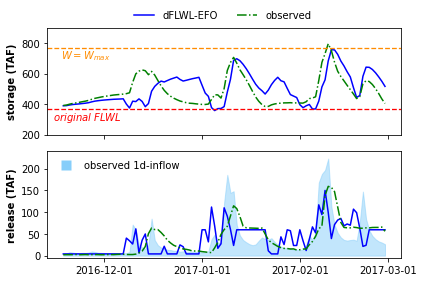

In [19]:
fig, ax = plt.subplots(2, 1,figsize=(6, 4), sharex=True)
ax[0].plot(df_result['date'], df_result['S1_FIRO'], color='b', label = 'dFLWL-EFO')
ax[0].plot(df_result['date'], df_result['S1_obs'], color='g', linestyle='-.', label = 'observed')
ax[0].set_ylabel('storage (TAF)',fontweight="bold", fontsize=10)
ax[0].set_ylim([200,900])
ax[0].legend(loc='upper left', bbox_to_anchor=(0.22, 1.25), ncol=3, frameon=False)
# storage thresholds
ax[0].axhline(y=767, linestyle='--', color='darkorange', linewidth=1.3)
fig.text(0.15, 0.79, "${W=W_{max}}$", color='darkorange')
ax[0].axhline(y=367, linestyle='--', color='red', linewidth=1.3)
fig.text(0.13, 0.575, "${original\ FLWL}$", color='red')

ax[1].plot(df_result['date'], df_result['R1_FIRO'], color='b', label = 'dFLWL-EFO')
ax[1].plot(df_result['date'], df_result['R1_obs'], color='g', linestyle = '-.', label = 'observed')
ax[1].fill_between(df_result["date"], df_result["I1"], 0, color='lightskyblue', alpha=0.5)
ax[1].set_ylabel('release (TAF)', fontweight="bold",fontsize=10)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%
legend_elements = [Line2D([0], [0], marker='s', color='none', label='observed 1d-inflow',
                          markerfacecolor='lightskyblue', markeredgecolor='none', markersize=10)]
ax[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), ncol=1, fontsize=10, frameon=False)     

#ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=1)
ax[1].set_ylim([-5,240])
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
